In [25]:
import geopandas as gpd
import pandas as pd
import copy
import os
import warnings
import random
from pprint import pprint
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from srai.datasets import AirbnbMulticityDataset
from srai.embedders import Hex2VecEmbedder
from srai.joiners import IntersectionJoiner
from srai.loaders.osm_loaders import OSMPbfLoader
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER
from srai.neighbourhoods.h3_neighbourhood import H3Neighbourhood
from srai.plotting import plot_regions
from srai.regionalizers import H3Regionalizer
import plotly.graph_objs as go
from shapely.geometry import LineString, Point
from shapely import from_geojson
import h3
from srai.h3 import h3_to_geoseries
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = self.X.iloc[idx].values
        y_val = self.y.iloc[idx]

        X_tensor = torch.tensor([item for item in X_seq], dtype=torch.float32)
        y_tensor = torch.tensor(y_val, dtype=torch.float32)

        return X_tensor, y_tensor

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out


In [32]:
H3_RESOLUTION = 9
seq_length = 8
data_path = 'input_data'
path = f'data_res{H3_RESOLUTION}_seq{seq_length}'
path = os.path.join(data_path, path)

In [34]:
X_train, y_train = torch.load(os.path.join(path, 'train.pt'))
X_test, y_test = torch.load(os.path.join(path, 'test.pt'))

In [35]:
# (3624, 5) (3624,)
# # (907, 5) (907,)

# (35594, 5) (35594,)
# (8899, 5) (8899,)

# (101627, 5) (101627,)
# (25407, 5) (25407,)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(97874, 8) (97874,)
(24469, 8) (24469,)


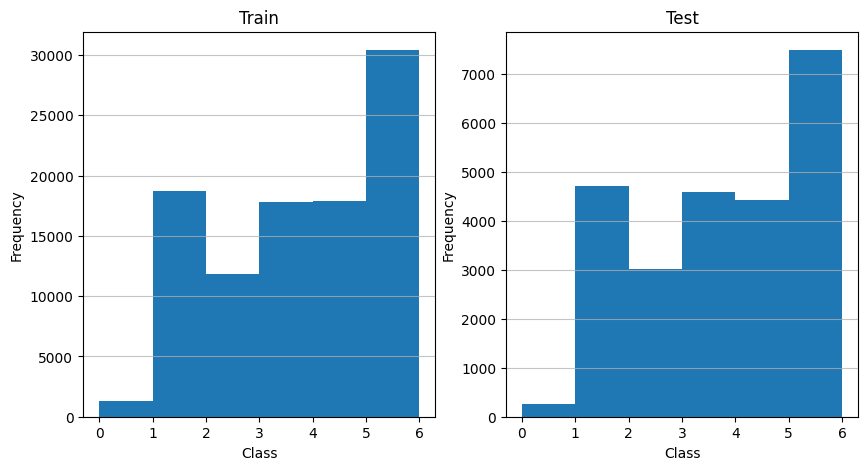

In [36]:
dist = []
for i in y_train:
    id_max = np.argmax(i)
    dist.append(id_max)
    
test_dist = []
for i in y_test:
    id_max = np.argmax(i)
    test_dist.append(id_max)
    
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dist, bins=range(7))
ax[0].set_title('Train')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
ax[0].grid(axis='y', alpha=0.75)
    
ax[1].hist(test_dist, bins=range(7))
ax[1].set_title('Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
ax[1].grid(axis='y', alpha=0.75)
plt.show()

In [37]:
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# EXP 1

In [38]:
input_size = len(X_train.iloc[0][0])
hidden_size = 128
output_size = 7
num_layers = 2
dropout_rate = 0.5

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Epoch [1/60], Loss: 1.6166, Val Loss: 1.2922
Epoch [2/60], Loss: 1.2663, Val Loss: 1.1778
Epoch [3/60], Loss: 1.1836, Val Loss: 1.1268
Epoch [4/60], Loss: 1.1360, Val Loss: 1.0929
Epoch [5/60], Loss: 1.0952, Val Loss: 1.0809
Epoch [6/60], Loss: 1.0678, Val Loss: 1.0714
Epoch [7/60], Loss: 1.0422, Val Loss: 1.0411
Epoch [8/60], Loss: 1.0203, Val Loss: 1.0326
Epoch [9/60], Loss: 1.0003, Val Loss: 1.0151
Epoch [10/60], Loss: 0.9790, Val Loss: 1.0203
Epoch [11/60], Loss: 0.9644, Val Loss: 0.9981
Epoch [12/60], Loss: 0.9509, Val Loss: 0.9879
Epoch [13/60], Loss: 0.9395, Val Loss: 0.9946
Epoch [14/60], Loss: 0.9273, Val Loss: 0.9931
Epoch [15/60], Loss: 0.9178, Val Loss: 0.9924
Epoch [16/60], Loss: 0.9060, Val Loss: 0.9785
Epoch [17/60], Loss: 0.8966, Val Loss: 0.9846
Epoch [18/60], Loss: 0.8876, Val Loss: 0.9814
Epoch [19/60], Loss: 0.8786, Val Loss: 1.0021
Epoch [20/60], Loss: 0.8708, Val Loss: 0.9844
Epoch [21/60], Loss: 0.8649, Val Loss: 0.9798
Epoch [22/60], Loss: 0.8587, Val Loss: 0.98

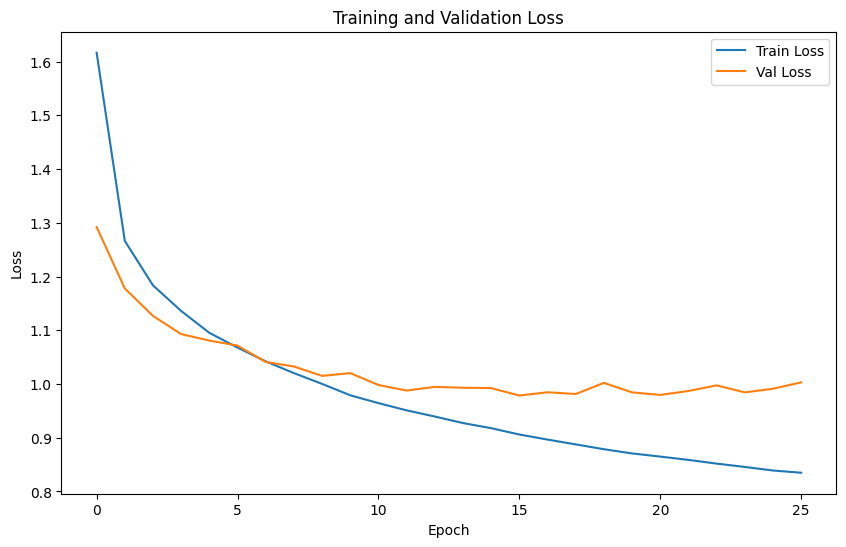

In [39]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

patience = 10
num_epochs = 60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted_one_hot = torch.nn.functional.one_hot(preds, num_classes=7).float()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# best model
model.load_state_dict(torch.load('best_model.pth'))

# Train/test plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [40]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.array(predicted_labels)

In [41]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.37      0.23      0.29       256
           1       0.69      0.72      0.70      4704
           2       0.67      0.41      0.51      3012
           3       0.62      0.71      0.66      4583
           4       0.64      0.75      0.69      4423
           5       0.62      0.43      0.51      2953
           6       0.62      0.70      0.65      4538

    accuracy                           0.64     24469
   macro avg       0.60      0.56      0.57     24469
weighted avg       0.64      0.64      0.63     24469



In [42]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.6399
Precision: 0.6403
Recall: 0.6399
F1-score: 0.6323


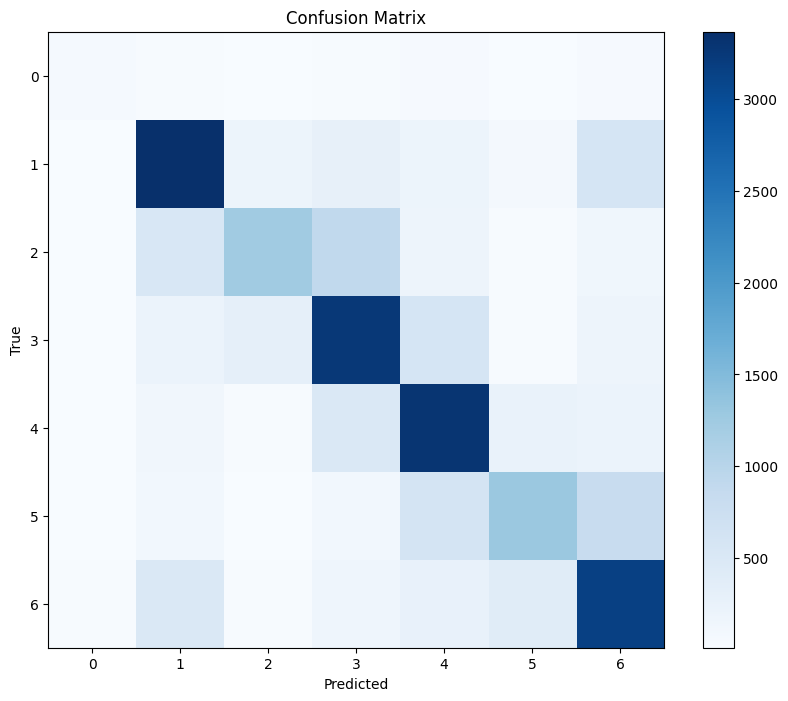

In [43]:
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix(true_labels, predicted_labels), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# EXP 2

In [45]:
input_size = len(X_train.iloc[0][0])
hidden_size = 64
output_size = 7
num_layers = 2
dropout_rate = 0.6

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

patience = 10
num_epochs = 150

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted_one_hot = torch.nn.functional.one_hot(preds, num_classes=7).float()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# best model
model.load_state_dict(torch.load('best_model.pth'))

# Train/test plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch [1/150], Loss: 1.7089, Val Loss: 1.4423
Epoch [2/150], Loss: 1.3948, Val Loss: 1.2820
Epoch [3/150], Loss: 1.3045, Val Loss: 1.2023
Epoch [4/150], Loss: 1.2634, Val Loss: 1.1710
Epoch [5/150], Loss: 1.2352, Val Loss: 1.1614
Epoch [6/150], Loss: 1.2072, Val Loss: 1.1411
Epoch [7/150], Loss: 1.1920, Val Loss: 1.1245
Epoch [8/150], Loss: 1.1768, Val Loss: 1.1241


In [ ]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.array(predicted_labels)

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(classification_report(true_labels, predicted_labels))

In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix(true_labels, predicted_labels), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()